In [1]:
# import libraries
import numpy as np 
import pandas as pd
import statsmodels.stats.power as smp
import matplotlib.pyplot as plt

In [2]:
# let scientists compete against each other throughout their entire lifespan
def competition(lifeSpan, sampleSize, scientistPerQuestionMax, startupCost, sampleCost, ExpDistributionShape, scoopedCost, negativeResultCost, limit, newQuestionCost, randomChance, chance):
    oneYear = lifeSpan/20 # definition of one year in time units, career of scientist takes 20 years
    scientistID = list(np.arange(populationSize)) # list with scientist IDs
    amountOfQuestions = round((lifeSpan / (startupCost + minSampleSize)) * populationSize + populationSize) # generates number of questions
    questionID = list(np.arange(amountOfQuestions)) # list with question IDs
    effectSizeQuestion = list(np.round(np.array(np.random.exponential(1/ExpDistributionShape, size=amountOfQuestions)), 1)) # list with effect sizes drawn from a uniform distribution
    drawerQ = list(np.array(np.zeros(shape=[populationSize, 0]),np.int32)) # integer list of completed question IDs indexed by scientist ID
    drawerR = list(np.array(np.zeros(shape=[populationSize, 0]),np.bool_)) # boolean list of completed question results indexed by scientist ID
    drawerP = []
    drawerU = []
    
   
    
    if randomChance == True:
        chanceNewQ = list(np.random.randint(0, 10, size=populationSize))
    else:
        chanceNewQ = chance
    
    # create scientist dataframe
    d1 = {'scientistID' : scientistID, 'sampleSize' : sampleSize, 'questionID' : 0, 'publications' : 0, 'payoff' : 0.0,'chance': chanceNewQ }
    scientistDataFrame = pd.DataFrame(data=d1)

    # create results dataframe
    d2 = {'questionID' : questionID, 'scientistID' : -1, 'sampleSize' : 0, 'effectSize': effectSizeQuestion,'result' : 0, 'published':None}
    resultsDataFrame = pd.DataFrame(data=d2)
    
    
    # question trackers
    questionIDsPublished = [] # list of questions that have been published
    questionIDsWorked = [] # list of questions that have been completed
    
    # time (cost) trackers
    timePeriod = 1 #start
    timeCost = list(scientistDataFrame['sampleSize'] * sampleCost + startupCost) # real-time tracker
    timeCostBaseline = list(scientistDataFrame['sampleSize'] * sampleCost + startupCost) # baseline tracker
    extraTimeCost = [0] * populationSize

    # assign scientists to questions
    scientistDataFrame['questionID'] = np.repeat(questionID, scientistPerQuestionMax)[:len(scientistDataFrame['scientistID'])] 

    # create a list that keeps track of amount of scientists on a question
    filledQuestions = pd.crosstab(index=scientistDataFrame['questionID'], columns="count") #creates df with questionid and nr of scientis working on it
    emptyQuestions = (amountOfQuestions - len(filledQuestions)) * [0] # creates a list with 0's with len of unused questions
    emptyQuestions = pd.DataFrame(emptyQuestions, columns=["count"]) # df of question id and nr of scientis working on 
    questionDataFrame = filledQuestions.append(emptyQuestions, ignore_index= True) # combine the two df's 
    scientistPerQuestion = list(questionDataFrame['count']) #create a list of the count df

    
    yearProgress = oneYear # time to next year tracker
    unpubQ = questionID # list of all questions that have been worked on
    
    while(timePeriod < lifeSpan):
            
        # calculate time to next event: end of year / completed research / end of lifespan
        timeToNextEvent = min(yearProgress, min( min(timeCost), lifeSpan - timePeriod)) 
        
        # update time trackers
        if limit:
            yearProgress = yearProgress - timeToNextEvent # update time to next year tracker
        timeCost = list(timeCost - np.repeat(timeToNextEvent, len(timeCost))) # update timecost tracker for every scientist
        timePeriod = timePeriod + timeToNextEvent # update the current model time
        if (timePeriod > lifeSpan):
            break
        
        if (min(timeCost) == 0): # studies are completed -> scientists store questions into their drawer
            if limit == False:
                yearProgress = 0
            # trackers for scientists who completed a study
            actingScientists = np.array([i for i, noTimeLeft in enumerate(timeCost) if noTimeLeft == 0]) # retrieves the indeces of people who have finished sampling
            amountActingScientists = len(actingScientists) # count amount of scientists who have completed their study
            questionActingScientists = list(scientistDataFrame[scientistDataFrame['scientistID'].isin(actingScientists)]['questionID']) # retrieve question IDs of questions that have been completed

            # store effect sizes and sample sizes of completed questions
            effectSizeQuestion = [] # create list for effect sizes of completed questions
            for i in questionActingScientists: # for every completed question index
                effectSizeQuestion.append(resultsDataFrame.loc[[i],'effectSize']) # store the effect size from the resultsDataFrame in the list of effect sizes of completed questions
            sampleSizeActingScientists = list(scientistDataFrame[scientistDataFrame['scientistID'].isin(actingScientists)]['sampleSize']) # list of sample sizes of completed questions


            # store statistical powers of the completed questions
            sampleSizeIndex = 0 # sample size index tracker
            powerOfQuestions = [] # list of powers of completed questions
            for qid in questionActingScientists: # for every completed question
                    resultsDataFrame.at[qid,'published'] = False
                    powerOfQuestion =  smp.ttest_power( effect_size= resultsDataFrame._get_value(qid, 'effectSize'),
                                                       nobs=sampleSizeActingScientists[sampleSizeIndex], 
                                                       alpha=0.05, alternative='two-sided') # calculate the power
                    powerOfQuestions.append(powerOfQuestion) # add power to list of powers of completed questions
                    sampleSizeIndex += 1 # increase sample size index tracker by one
            
            # simulate the result of a completed question based on the power
            positiveResult = [] # list of boolean results for completed questions
            for r in range(amountActingScientists): # for each completed question
                positiveResult.append(np.random.uniform(0,1) < powerOfQuestions[r]) # store positive or negative result based on power and a drawn value from a uniform distribution
            
            for sid in actingScientists: # for every acting scientist
                qid = questionActingScientists[np.where(actingScientists == sid)[0][0]] # retrieve the question ID they completed
                drawerQ[sid] = np.append(drawerQ[sid], [qid]) # add question ID to drawer
                drawerR[sid] = np.append(drawerR[sid], [positiveResult[np.where(actingScientists == sid)[0][0]]]) # add question result to drawer
            # update completed question tracker
            questionIDsWorked = np.concatenate((questionIDsWorked, questionActingScientists)) # add completed questions to the tracker
            
            # update the results dataframe 
            for sid in actingScientists: # for every scientist that completed a question
                qid = questionActingScientists[np.where(actingScientists == sid)[0][0]] # retrieve the question ID they completed
                resultsDataFrame.loc[[qid],'scientistID'] = sid # add scientist ID to results dataframe
                resultsDataFrame.loc[[qid],'sampleSize'] = sampleSizeActingScientists[np.where(actingScientists == sid)[0][0]] # add sample size to results dataframe
                resultsDataFrame.loc[[qid],'result'] = positiveResult[np.where(actingScientists == sid)[0][0]] # add result to results dataframe

            # find assignable questions and assign scientists to a new question
            for sid in actingScientists: # for every scientist
                nextQuestion = np.random.choice(unpubQ)
                if resultsDataFrame.loc[[qid],'effectSize'].item() > resultsDataFrame.loc[[nextQuestion],'effectSize'].item() and scientistDataFrame.loc[[sid],'chance'].item() != 0:
                    if  np.random.choice(scientistDataFrame.loc[[sid],'chance'].item(), 1) == 0:
                        nextQuestion = np.random.choice(unpubQ)
                        extraTimeCost[sid] = extraTimeCost[sid] + newQuestionCost
            
                scientistPerQuestion[qid] -= 1 # decrease number of scientist working on the completed question by one
                scientistPerQuestion[nextQuestion] += 1 # increase number of scientist working on the next question by one
                scientistDataFrame.loc[[
                    resultsDataFrame.loc[[qid],'scientistID'].item()], 'questionID'] = nextQuestion # update scientist dataframe with the new question ID

            # adjust the baseline
            for sid in actingScientists: # for every scientist
                timeCost[sid] = timeCostBaseline[sid] + extraTimeCost[sid]  # reset their time cost to the baseline value
            
            extraTimeCost = [0] * populationSize
                
        elif yearProgress == 0: # end of year -> scientists publish their papers
            yearProgress = oneYear # reset time to next year tracker
            
            for sid in np.repeat(scientistDataFrame['scientistID'], paperLimit): # for each scientist
                workedQ = drawerQ[sid] # retrieve all completed, unpublished questions from their drawer
                if len(workedQ) != 0: # if their drawer is not empty
                    payoff = 0 # initialize payoff
                    
                    # find question with highest payoff in a scientist's drawer and publish it
                    for q in range(len(workedQ)): # for each completed, unpublished question
                        priorPublished = questionIDsPublished.count(workedQ[q]) # count prior published works on this question
                        noveltyResult = pow( (1/(1+priorPublished)), scoopedCost) # calculate novelty of this question based on novelty and scooping cost
                        if drawerR[sid][q]: # if the result of the completed, unpublished question is positive 
                            possiblepayoff = noveltyResult # the possible payoff is equal to the payoff of a novel result
                        else: # if the result of the completed, unpublished question is negative
                            possiblepayoff = noveltyResult * negativeResultCost # the possible payoff is equal to the payoff of a novel result scaled down with the cost of a negative result
                        if possiblepayoff > payoff: # if a completed, unpublished question is found with a higher possible payoff than the current stored payoff
                            tempq = q # question to publish becomes the current completed, unpublished question
                            payoff = possiblepayoff # payoff becomes the highest possible payoff
                    payoff = np.round(payoff,2) # round payoff to two decimals
                    # publish question with the highest possible payoff
                    scientistDataFrame.at[sid, 'payoff'] = scientistDataFrame.at[sid, 'payoff'].astype(float) + payoff # add payoff to scientist's previous payoffs
                    scientistDataFrame.at[sid, 'publications'] = scientistDataFrame.at[sid, 'publications'].astype(int) + 1 # increase number of scientist's publications by one
                    questionIDsPublished.append(drawerQ[sid][tempq]) # add now published question to the list of published questions
                    resultsDataFrame.at[drawerQ[sid][tempq],'published'] = True # change published status to True
                    
                    drawerP.append([resultsDataFrame.loc[[drawerQ[sid][tempq]],'effectSize'].item(),drawerR[sid][tempq]])
                    
                    # remove the completed, published question from the drawer of completed, unpublished questions
                    if drawerQ[sid][tempq] in unpubQ:
                        unpubQ.remove(drawerQ[sid][tempq])
                    drawerQ[sid] = np.delete(drawerQ[sid], tempq) # remove question from drawer with question IDs
                    drawerR[sid] = np.delete(drawerR[sid], tempq) # remove question from drawer with question results
                    
    
    for sid in scientistDataFrame['scientistID']:
        for q in range(len(drawerQ[sid])):
            drawerU.append([resultsDataFrame.loc[[drawerQ[sid][q]],'effectSize'].item(),drawerR[sid][q]])
        
    publishedDataFrame = pd.DataFrame(data=drawerP, columns = ['effectSize','result'])
    unpublishedDataFrame = pd.DataFrame(data=drawerU, columns = ['effectSize','result'])
    finishedDataFrame =  resultsDataFrame[(resultsDataFrame['published'] == True) | (resultsDataFrame['published'] == False)].reset_index() # store all finished questions in dataframe  
          

    return scientistDataFrame , resultsDataFrame, finishedDataFrame, drawerQ, publishedDataFrame, unpublishedDataFrame  # return scientist dataframe

In [19]:
# run generations of scientists that compete against each other and evolve
def evolution(lifeSpan, scientistPerQuestionMax, generations, startupCost, sampleCost, ExpDistributionShape, scoopedCost, negativeResultCost, limit, newQuestionCost, randomChance, chance):
    
    for run in range(10):
        print('Run: '+ str(run))
        
        # initialize population
        sampleSize = np.round(np.random.uniform(minSampleSize, maxSampleSize, populationSize)) # draw sample sizes from a uniform distribution
        meanSampleSizes = []   # list of mean sample sizes
        meanPayoffs = []       # list of mean payoffs
        meanPublished = []     # list of mean number of published questions
        maxQ = []             # list of mean question IDs
        meanChance = []
        percFalsePosAll = []   # list of percentages of false positives (all finished questions)
        percFalsePosPub = []   # list of percentages of false positives (all published questions)
        percFalsePosUnpub = [] # list of percentages of false positives (all unpublished questions)
        percFalseNegAll = []   # list of percentages of false negatives (all finished questions)
        percFalseNegPub = []   # list of percentages of false negatives (all published questions)
        percFalseNegUnpub = [] # list of percentages of false negatives (all unpublished questions)
        generationsPlot = (np.arange(generations)) + 1 
        drawerSizes = []
        percPosPublished = []
        trackFalsePos = []
        trackFalseNeg = []
        trackFalsePosPub = []
        trackFalseNegPub = []


        for g in range(generations): # for every generation 
            print("working on generation: ",g+1,"/",generations)
            result = competition(lifeSpan, sampleSize, scientistPerQuestionMax, startupCost, sampleCost, 
                                          ExpDistributionShape, scoopedCost, negativeResultCost, limit, newQuestionCost, randomChance, chance) # return scientist dataframe
            outcomeGeneration = result[0]
            # allocate new generation of scientists a sample size with payoffs of their predecessors as (probability) weights
            sampleSize = outcomeGeneration.sample(n=populationSize, weights='payoff', random_state=1, replace= True)['sampleSize'].to_numpy() 
            chance = outcomeGeneration.sample(n=populationSize, weights='payoff', random_state=1, replace= True)['chance'].to_numpy()

            for s in range(len(sampleSize)): # for each sample size
                sampleSize[s] = np.absolute(np.round(np.random.normal(sampleSize[s], 1.5, 1))) # introduce noise

            meanSampleSizes.append(outcomeGeneration["sampleSize"].mean()) # add mean sample size to list of mean sample sizes
            meanPayoffs.append(outcomeGeneration["payoff"].mean())         # add mean payoff to list of mean payoffs
            meanPublished.append(outcomeGeneration["publications"].mean()) # add mean number of published questions to list of mean number of published questions
            maxQ.append(outcomeGeneration["questionID"].max())           # add mean question ID to list of mean question IDs
            meanChance.append(outcomeGeneration["chance"].mean())

            finishedDataFrame = result[2] # retrieve finished questions dataframe

            published = result[4]
            #print(published)
            unpublished = result[5]
            frames = [published, unpublished]
            allResearched = pd.concat(frames)

            # calculating false positive and false negative rates for all finished questions
            lenFinished = len(allResearched) # number of finished questions
            falsePosAll = (allResearched['effectSize'] == 0.0) & (allResearched['result'] == True) # false positive boolean mask
            falseNegAll = (allResearched['effectSize'] > 0.0) & (allResearched['result'] == False) # false negative boolean mask
            nrFalsePosAll = allResearched[falsePosAll].count()[0] # number of false positives
            nrFalseNegAll = allResearched[falseNegAll].count()[0] # number of false negatives
            percFalsePosAll.append((nrFalsePosAll/lenFinished)*100) # add false positive percentage to list of false positives
            percFalseNegAll.append((nrFalseNegAll/lenFinished)*100) # add false negative percentage to list of false negatives

            # calculating false positive and false negative rates for all published questions
            lenFinishedPub = len(published) # number of published questions
            falsePosPub = (published['effectSize'] == 0.0) & (published['result'] == True) # false positive boolean mask
            falseNegPub = (published['effectSize'] > 0.0) & (published['result'] == False) # false positive boolean mask # false negative boolean mask
            nrFalsePosPub= published[falsePosPub].count()[0] # number of false positives
            nrFalseNegPub = published[falseNegPub].count()[0] # number of false negatives
            percFalsePosPub.append((nrFalsePosPub/lenFinishedPub)*100) # add false positive percentage to list of false positives
            percFalseNegPub.append((nrFalseNegPub/lenFinishedPub)*100) # add false negative percentage to list of false negatives

            # calculating false positive and false negative rates for all unpublished questions
            lenFinishedUnpub = len(unpublished) # number of unpublished questions
            falsePosUnpub = (unpublished['effectSize'] == 0.0) & (unpublished['result'] == True) # false positive boolean mask
            falseNegUnpub = (unpublished['effectSize'] > 0.0) & (unpublished['result'] == False) # false negative boolean mask
            nrFalsePosUnpub = unpublished[falsePosUnpub].count()[0] # number of false positives
            nrFalseNegUnpub = unpublished[falseNegUnpub].count()[0] # number of false negatives
            if lenFinishedUnpub > 0:
                percFalsePosUnpub.append((nrFalsePosUnpub/lenFinishedUnpub)*100) # add false positive percentage to list of false positives
                percFalseNegUnpub.append((nrFalseNegUnpub/lenFinishedUnpub)*100) # add false negative percentage to list of false negatives
            else:
                percFalsePosUnpub.append(0) # add false positive percentage to list of false positives
                percFalseNegUnpub.append(0) # add false negative percentage to list of false negatives

            #printProgressNew = outcomeGeneration[['sampleSize','payoff', 'publications']] 
            #printProgress = pd.concat([printProgress, printProgressNew], axis=1)
            #print(outcomeGeneration)

            trackFalsePos.append(nrFalsePosAll)
            trackFalseNeg.append(nrFalseNegAll)
            trackFalsePosPub.append(nrFalsePosPub)
            trackFalseNegPub.append(nrFalseNegPub)

            positives = np.sum(published['result'] == True)
            #print(positives)
            resultsTotal = len(published)
            if resultsTotal != 0:
                percPosPublished.append(100 * np.round((positives / resultsTotal), 2))
            else:
                percPosPublished.append(0)

            drawerSize = 0
            drawer = result[3]
            for i in range(populationSize):
                drawerSize += len(drawer[i])
            drawerSizes.append(drawerSize)

            ##outcomeGeneration.to_csv('file' + str(g) +'.csv')


        # plot mean payoff, mean sample size, mean number of published questions and mean question ID against generations
        fig, axs = plt.subplots(1,2)

        fig.suptitle('Progression with limit set to {}'.format(limit))
        axs[0].plot(generationsPlot, meanPayoffs, 'tab:orange')
        axs[0].set_title('Mean Payoffs')
        axs[0].set(ylim=(0, max(meanPayoffs)+max(meanPayoffs)/10))

        axs[1].plot(generationsPlot, meanSampleSizes,  'tab:green')
        axs[1].set_title('Mean SampleSize')
        axs[1].set(ylim=(0, max(meanSampleSizes)+max(meanSampleSizes)/10))

        fig, axs = plt.subplots(1,2)
        fig.suptitle( "Progression, limit = {}".format(limit) )

        axs[1].plot(generationsPlot, meanPublished, 'tab:red')
        axs[1].set_title('Mean Published')
        axs[1].set(ylim=(0, max(meanPublished)+max(meanPublished)/10))

        axs[0].plot(generationsPlot, maxQ, 'tab:orange')
        axs[0].set_title('Questions worked on')
        axs[0].set(ylim=(0, round((lifeSpanT / (startupCostT + minSampleSize)) * populationSize + populationSize)))

        fig, axs = plt.subplots(1,2)
        fig.suptitle('All finished questions, limit = {}'.format(limit) )
        axs[0].plot(generationsPlot, percFalsePosAll, 'tab:green')
        axs[0].set_title('Percentage False Positives')
        axs[0].set(ylim=(0, 101))

        axs[1].plot(generationsPlot, percFalseNegAll, 'tab:red')
        axs[1].set_title('Percentage False Negatives')
        axs[1].set(ylim=(0, 101))

        fig, axs = plt.subplots(1,2)
        fig.suptitle('All published questions, limit = {}'.format(limit))
        axs[0].plot(generationsPlot, percFalsePosPub, 'tab:green')
        axs[0].set_title('Percentage False Positives')
        axs[0].set(ylim=(0, 101))

        axs[1].plot(generationsPlot, percFalseNegPub, 'tab:red')
        axs[1].set_title('Percentage False Negatives')
        axs[1].set(ylim=(0, 101))

        fig, axs = plt.subplots(1,2)
        fig.suptitle('All unpublished questions, limit = {}'.format(limit))
        axs[0].plot(generationsPlot, percFalsePosUnpub, 'tab:green')
        axs[0].set_title('Percentage False Positives')
        axs[0].set(ylim=(0, 101))

        axs[1].plot(generationsPlot, percFalseNegUnpub, 'tab:red')
        axs[1].set_title('Percentage False Negatives')
        axs[1].set(ylim=(0, 101))

        fig, axs = plt.subplots(1,2)
        fig.suptitle('File-drawer, limit = {}'.format(limit))
        axs[0].plot(generationsPlot, drawerSizes, 'tab:red')
        axs[0].set_title('Papers file-drawer')
        axs[0].set(ylim=(0, max(drawerSizes)+10))

        axs[1].plot(generationsPlot, percPosPublished, 'tab:red')
        axs[1].set_title('% positive published results')
        axs[1].set(ylim=(0, 101))

        fig, axs = plt.subplots(1,2)

        fig.suptitle('Mean chace'.format(limit))
        axs[0].plot(generationsPlot, meanChance, 'tab:orange')
        axs[0].set_title('Mean chace')
        axs[0].set(ylim=(0, max(meanChance)+max(meanChance)/10))

        d5 = {'FP all': trackFalsePos, 'FN all' : trackFalseNeg, 'FP pub': trackFalsePosPub, 'FN pub': trackFalseNegPub }
        falseDataframe = pd.DataFrame(data=d5)
        print(falseDataframe)


        meanSampleSizeOverRuns.append(meanSampleSizes)
        meanPayoffsOverRuns.append(meanPayoffs)
    

In [20]:
meanSampleSizeOverRuns = []
meanPayoffsOverRuns = []

In [21]:
#number of scientists
populationSize = 120

#Scientists initial sample sizes 
minSampleSize = 2
maxSampleSize = 1000

# T = Test variable
lifeSpanT = 15000
scientistPerQuestionMaxT = 1
startupCostT = 125
sampleCostT = 1
ExpDistributionShapeT = 8
scoopedCostT = 0.5
negativeResultCostT = 0.5
paperLimit = 1
limit = True
newQuestionCost = 0
randomChance = False
chance = 0

generationsT = 100

# for x in range(2):
#     print("limit is {}".format(limit))
#     evolution (lifeSpanT, scientistPerQuestionMaxT, generationsT, startupCostT, sampleCostT, ExpDistributionShapeT, scoopedCostT, negativeResultCostT, limit)
#     limit = not limit

Run: 0
working on generation:  1 / 100
working on generation:  2 / 100
working on generation:  3 / 100
working on generation:  4 / 100
working on generation:  5 / 100
working on generation:  6 / 100
working on generation:  7 / 100
working on generation:  8 / 100
working on generation:  9 / 100
working on generation:  10 / 100
working on generation:  11 / 100
working on generation:  12 / 100
working on generation:  13 / 100
working on generation:  14 / 100
working on generation:  15 / 100
working on generation:  16 / 100
working on generation:  17 / 100
working on generation:  18 / 100
working on generation:  19 / 100
working on generation:  20 / 100
working on generation:  21 / 100
working on generation:  22 / 100
working on generation:  23 / 100
working on generation:  24 / 100
working on generation:  25 / 100
working on generation:  26 / 100
working on generation:  27 / 100
working on generation:  28 / 100
working on generation:  29 / 100
working on generation:  30 / 100
working on g

C:\Users\petru\anaconda3\lib\site-packages\ipykernel_launcher.py:182: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.


    FP all  FN all  FP pub  FN pub
0       72    1072      65     204
1       76    1353      71     268
2       77     978      72     196
3       80    1194      72     217
4       84    1570      77     241
..     ...     ...     ...     ...
95     135    3020     122     296
96     136    2973     122     266
97     131    2910     114     305
98     163    2955     153     279
99     126    2811     119     268

[100 rows x 4 columns]
Run: 1
working on generation:  1 / 100
working on generation:  2 / 100
working on generation:  3 / 100
working on generation:  4 / 100
working on generation:  5 / 100
working on generation:  6 / 100
working on generation:  7 / 100
working on generation:  8 / 100
working on generation:  9 / 100
working on generation:  10 / 100
working on generation:  11 / 100
working on generation:  12 / 100
working on generation:  13 / 100
working on generation:  14 / 100
working on generation:  15 / 100
working on generation:  16 / 100
working on generation:  17 / 1

C:\Users\petru\anaconda3\lib\site-packages\ipykernel_launcher.py:182: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.


    FP all  FN all  FP pub  FN pub
0       96    1353      87     224
1       81    1436      77     268
2       57    1615      51     239
3       85    1579      79     251
4       68    1670      61     272
..     ...     ...     ...     ...
95     156    3134     140     279
96     123    3482     116     295
97     149    3396     141     324
98     162    3570     150     326
99     131    3398     126     275

[100 rows x 4 columns]
Run: 2
working on generation:  1 / 100
working on generation:  2 / 100
working on generation:  3 / 100
working on generation:  4 / 100
working on generation:  5 / 100
working on generation:  6 / 100
working on generation:  7 / 100
working on generation:  8 / 100
working on generation:  9 / 100
working on generation:  10 / 100
working on generation:  11 / 100
working on generation:  12 / 100
working on generation:  13 / 100
working on generation:  14 / 100
working on generation:  15 / 100
working on generation:  16 / 100
working on generation:  17 / 1

C:\Users\petru\anaconda3\lib\site-packages\ipykernel_launcher.py:177: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\petru\anaconda3\lib\site-packages\ipykernel_launcher.py:182: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.


    FP all  FN all  FP pub  FN pub
0       73     967      65     204
1       65     985      60     233
2       65    1066      59     226
3       70    1332      63     281
4       96    1623      88     302
..     ...     ...     ...     ...
95     111    2123     104     253
96     118    2209     107     269
97     101    2364      90     306
98     124    1964     113     220
99     105    2002      99     240

[100 rows x 4 columns]
Run: 3
working on generation:  1 / 100
working on generation:  2 / 100
working on generation:  3 / 100
working on generation:  4 / 100
working on generation:  5 / 100
working on generation:  6 / 100
working on generation:  7 / 100
working on generation:  8 / 100
working on generation:  9 / 100
working on generation:  10 / 100
working on generation:  11 / 100
working on generation:  12 / 100
working on generation:  13 / 100
working on generation:  14 / 100
working on generation:  15 / 100
working on generation:  16 / 100
working on generation:  17 / 1

C:\Users\petru\anaconda3\lib\site-packages\ipykernel_launcher.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\petru\anaconda3\lib\site-packages\ipykernel_launcher.py:126: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\petru\anaconda3\lib\site-packages\ipykernel_launcher.py:137: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max

    FP all  FN all  FP pub  FN pub
0       82    1281      76     209
1       66    1594      60     264
2       80    1562      74     200
3       73    1297      65     237
4       68    1257      63     221
..     ...     ...     ...     ...
95     100    2768      87     269
96     126    2633     116     235
97     134    2776     125     245
98     122    2863     113     321
99     149    2788     134     283

[100 rows x 4 columns]
Run: 4
working on generation:  1 / 100
working on generation:  2 / 100
working on generation:  3 / 100
working on generation:  4 / 100
working on generation:  5 / 100
working on generation:  6 / 100
working on generation:  7 / 100
working on generation:  8 / 100
working on generation:  9 / 100
working on generation:  10 / 100
working on generation:  11 / 100
working on generation:  12 / 100
working on generation:  13 / 100
working on generation:  14 / 100
working on generation:  15 / 100
working on generation:  16 / 100
working on generation:  17 / 1

C:\Users\petru\anaconda3\lib\site-packages\ipykernel_launcher.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\petru\anaconda3\lib\site-packages\ipykernel_launcher.py:126: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\petru\anaconda3\lib\site-packages\ipykernel_launcher.py:137: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max

    FP all  FN all  FP pub  FN pub
0       54     999      51     240
1       58    1070      52     222
2       69    1323      64     234
3       69    1603      62     273
4       87    1553      78     265
..     ...     ...     ...     ...
95     118    2441     108     282
96     126    2199     117     264
97     112    2378     102     276
98      98    2451      95     276
99     132    2492     122     258

[100 rows x 4 columns]
Run: 5
working on generation:  1 / 100
working on generation:  2 / 100
working on generation:  3 / 100
working on generation:  4 / 100
working on generation:  5 / 100
working on generation:  6 / 100
working on generation:  7 / 100
working on generation:  8 / 100
working on generation:  9 / 100
working on generation:  10 / 100
working on generation:  11 / 100
working on generation:  12 / 100
working on generation:  13 / 100
working on generation:  14 / 100
working on generation:  15 / 100
working on generation:  16 / 100
working on generation:  17 / 1

C:\Users\petru\anaconda3\lib\site-packages\ipykernel_launcher.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\petru\anaconda3\lib\site-packages\ipykernel_launcher.py:126: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\petru\anaconda3\lib\site-packages\ipykernel_launcher.py:137: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max

    FP all  FN all  FP pub  FN pub
0       68    1197      61     262
1       60    1144      54     230
2      100    1209      91     235
3       82    1312      74     240
4       57    1250      55     267
..     ...     ...     ...     ...
95      97    2535      90     310
96     109    2415     100     253
97     103    2392      96     275
98     117    2399     104     269
99     104    2776      94     309

[100 rows x 4 columns]
Run: 6
working on generation:  1 / 100
working on generation:  2 / 100
working on generation:  3 / 100
working on generation:  4 / 100
working on generation:  5 / 100
working on generation:  6 / 100
working on generation:  7 / 100
working on generation:  8 / 100
working on generation:  9 / 100
working on generation:  10 / 100
working on generation:  11 / 100
working on generation:  12 / 100
working on generation:  13 / 100
working on generation:  14 / 100
working on generation:  15 / 100
working on generation:  16 / 100
working on generation:  17 / 1

C:\Users\petru\anaconda3\lib\site-packages\ipykernel_launcher.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\petru\anaconda3\lib\site-packages\ipykernel_launcher.py:126: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\petru\anaconda3\lib\site-packages\ipykernel_launcher.py:137: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max

    FP all  FN all  FP pub  FN pub
0       61    1107      53     249
1       76    1316      65     249
2       70    1502      69     275
3       84    1372      78     224
4       87    1571      81     269
..     ...     ...     ...     ...
95     110    2631     100     333
96     155    2686     135     291
97     127    2637     115     267
98     119    2269     112     228
99     130    2086     120     217

[100 rows x 4 columns]
Run: 7
working on generation:  1 / 100
working on generation:  2 / 100
working on generation:  3 / 100
working on generation:  4 / 100
working on generation:  5 / 100
working on generation:  6 / 100
working on generation:  7 / 100
working on generation:  8 / 100
working on generation:  9 / 100
working on generation:  10 / 100
working on generation:  11 / 100
working on generation:  12 / 100
working on generation:  13 / 100
working on generation:  14 / 100
working on generation:  15 / 100
working on generation:  16 / 100
working on generation:  17 / 1

C:\Users\petru\anaconda3\lib\site-packages\ipykernel_launcher.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\petru\anaconda3\lib\site-packages\ipykernel_launcher.py:126: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\petru\anaconda3\lib\site-packages\ipykernel_launcher.py:137: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max

    FP all  FN all  FP pub  FN pub
0       77    1223      71     244
1       78    1649      69     267
2       66    1361      63     232
3       85    1443      76     196
4       90    1581      80     276
..     ...     ...     ...     ...
95     135    2794     125     295
96     134    3071     122     368
97     107    3352      97     329
98     159    3681     144     399
99     156    3534     139     311

[100 rows x 4 columns]
Run: 8
working on generation:  1 / 100
working on generation:  2 / 100
working on generation:  3 / 100
working on generation:  4 / 100
working on generation:  5 / 100
working on generation:  6 / 100
working on generation:  7 / 100
working on generation:  8 / 100
working on generation:  9 / 100
working on generation:  10 / 100
working on generation:  11 / 100
working on generation:  12 / 100
working on generation:  13 / 100
working on generation:  14 / 100
working on generation:  15 / 100
working on generation:  16 / 100
working on generation:  17 / 1

C:\Users\petru\anaconda3\lib\site-packages\ipykernel_launcher.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\petru\anaconda3\lib\site-packages\ipykernel_launcher.py:126: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\petru\anaconda3\lib\site-packages\ipykernel_launcher.py:137: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max

    FP all  FN all  FP pub  FN pub
0       43     965      43     218
1       59     847      50     178
2       78     870      71     183
3       73    1296      69     254
4       97    1453      90     256
..     ...     ...     ...     ...
95     122    2522     115     264
96     107    2787      96     293
97     126    2701     117     286
98     143    2623     125     306
99     107    2599     105     294

[100 rows x 4 columns]
Run: 9
working on generation:  1 / 100
working on generation:  2 / 100
working on generation:  3 / 100
working on generation:  4 / 100
working on generation:  5 / 100
working on generation:  6 / 100
working on generation:  7 / 100
working on generation:  8 / 100
working on generation:  9 / 100
working on generation:  10 / 100
working on generation:  11 / 100
working on generation:  12 / 100
working on generation:  13 / 100
working on generation:  14 / 100
working on generation:  15 / 100
working on generation:  16 / 100
working on generation:  17 / 1

C:\Users\petru\anaconda3\lib\site-packages\ipykernel_launcher.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\petru\anaconda3\lib\site-packages\ipykernel_launcher.py:126: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\petru\anaconda3\lib\site-packages\ipykernel_launcher.py:137: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max

    FP all  FN all  FP pub  FN pub
0       74     975      67     249
1       80    1177      74     245
2       73    1208      67     194
3      103    1238      98     240
4       67    1318      61     250
..     ...     ...     ...     ...
95     100    2440      94     296
96     102    2726      92     318
97     137    2292     123     258
98     123    2216     108     257
99      93    2197      88     257

[100 rows x 4 columns]
Wall time: 7h 56min 2s


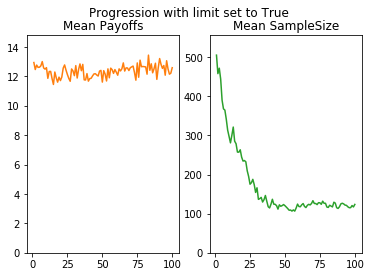

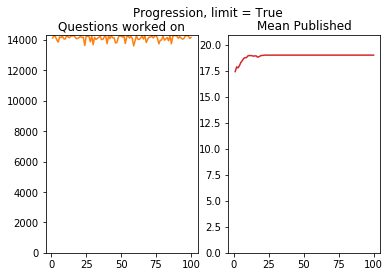

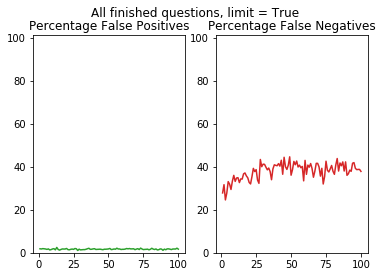

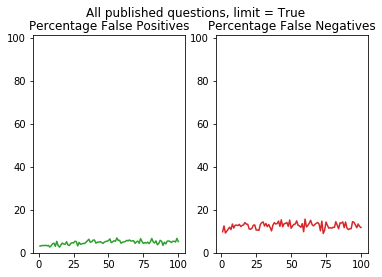

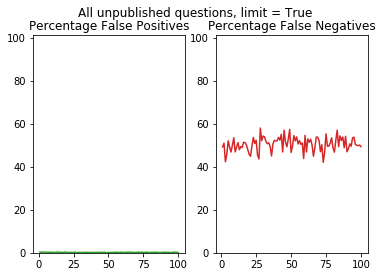

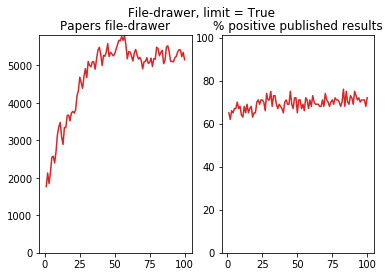

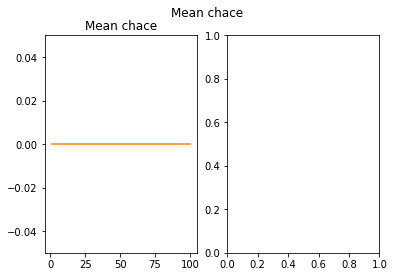

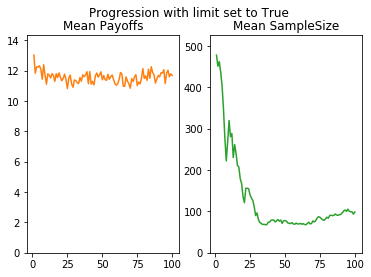

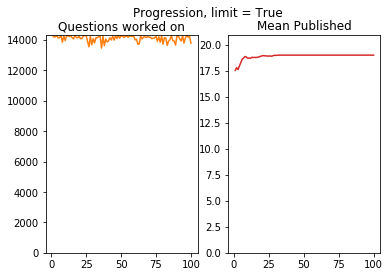

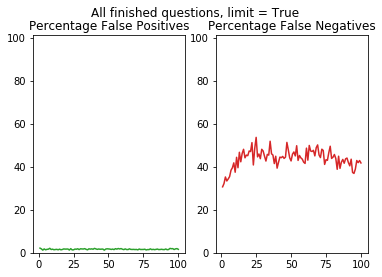

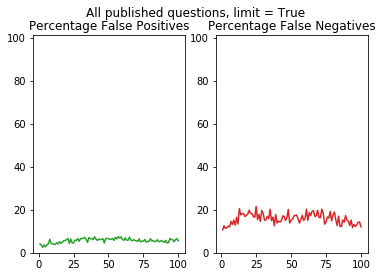

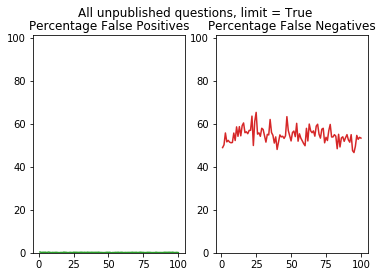

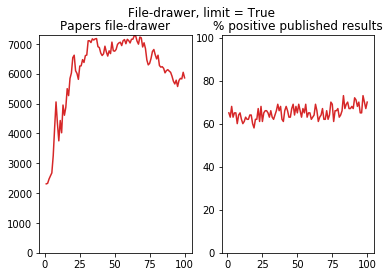

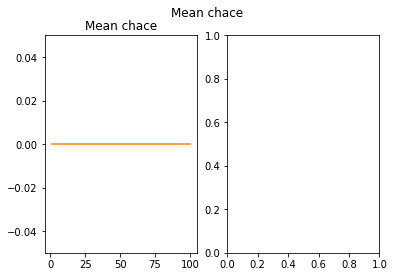

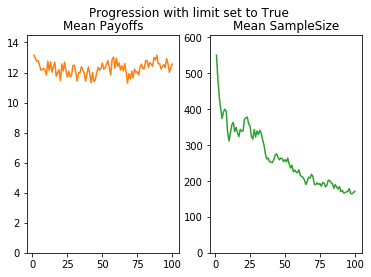

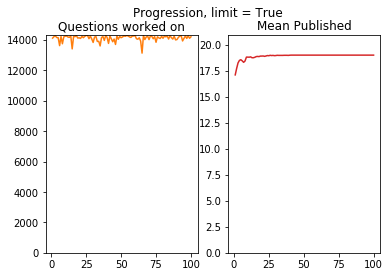

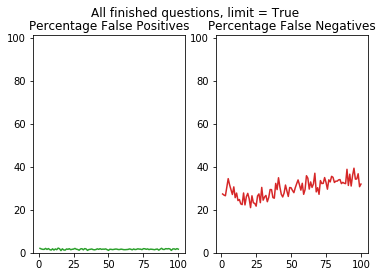

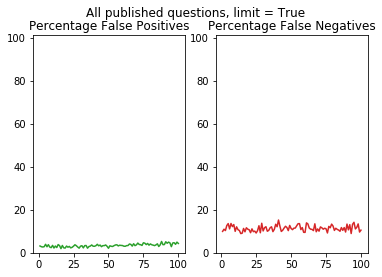

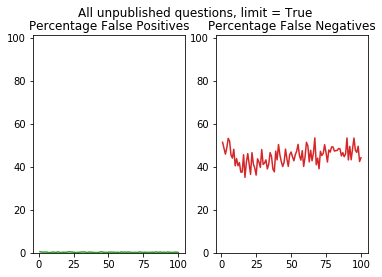

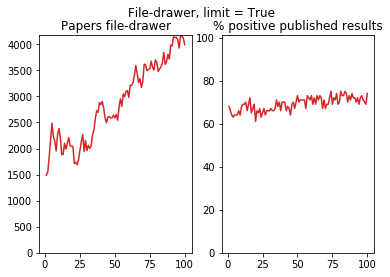

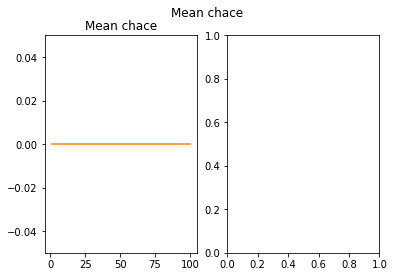

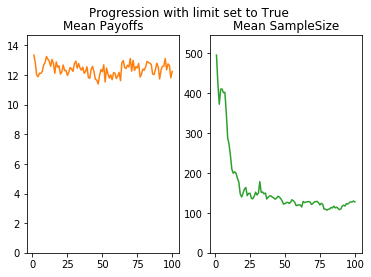

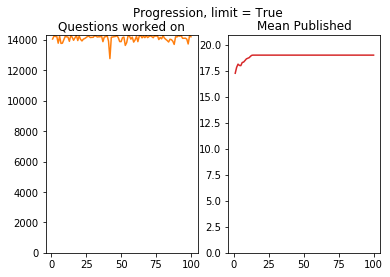

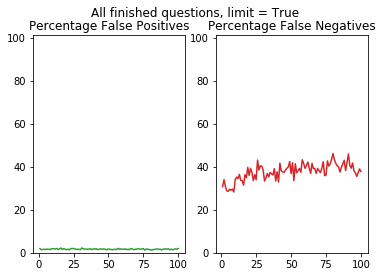

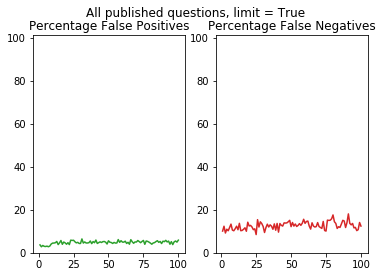

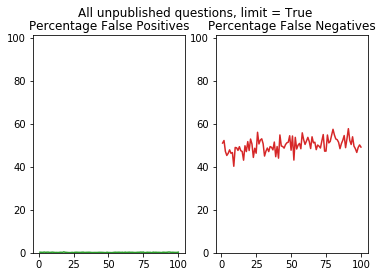

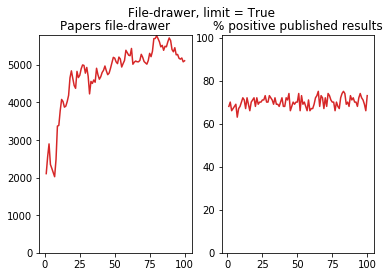

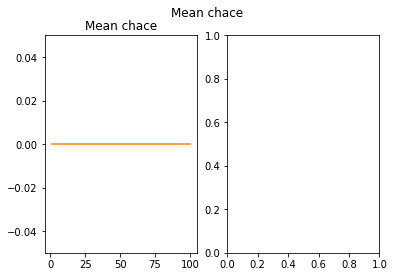

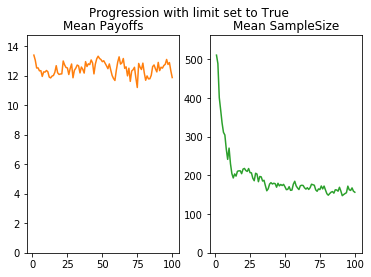

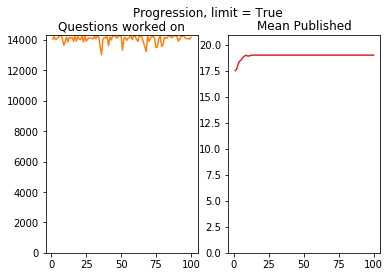

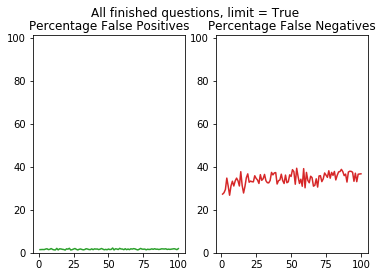

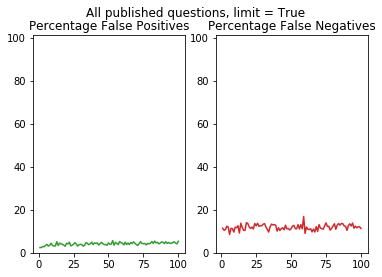

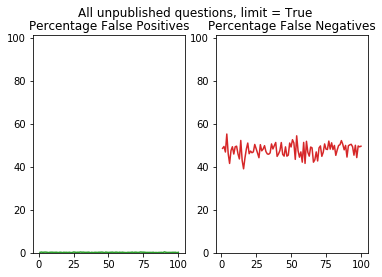

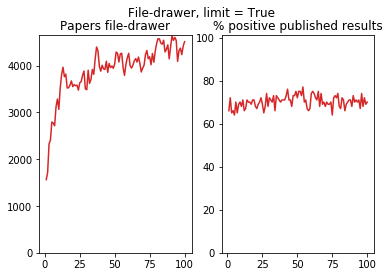

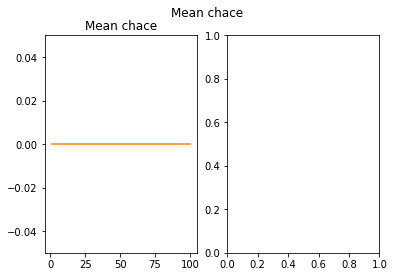

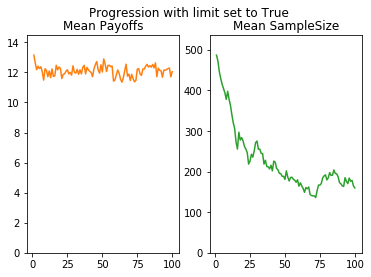

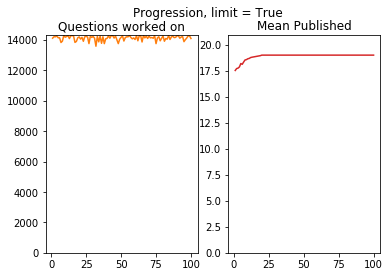

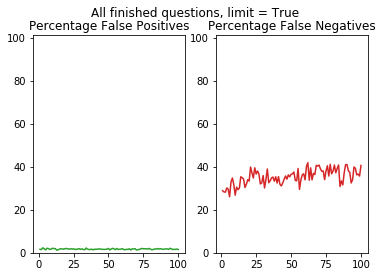

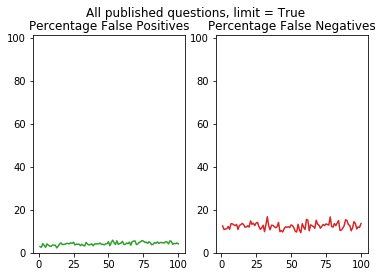

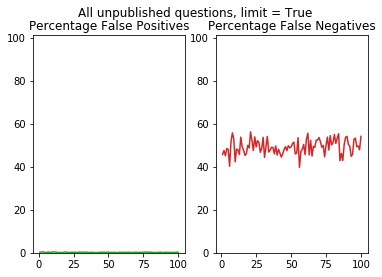

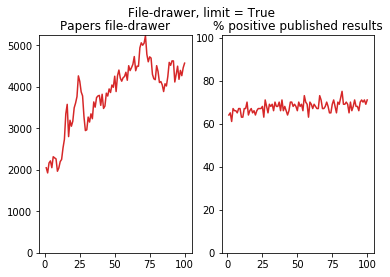

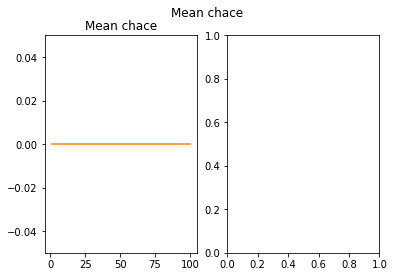

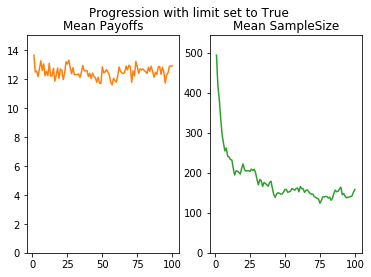

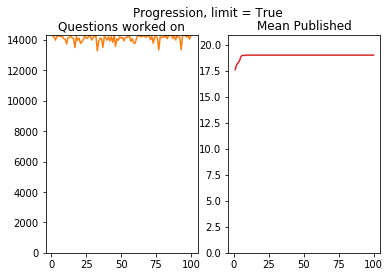

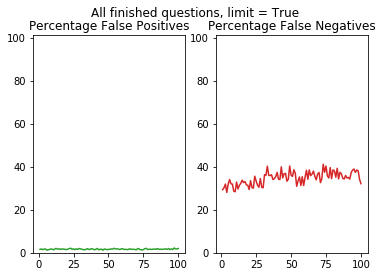

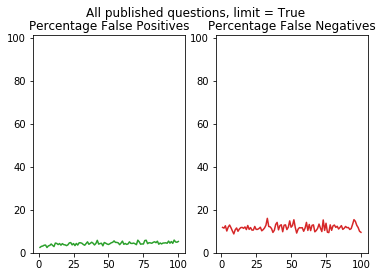

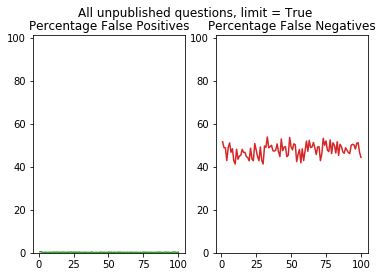

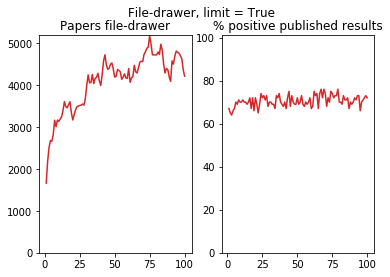

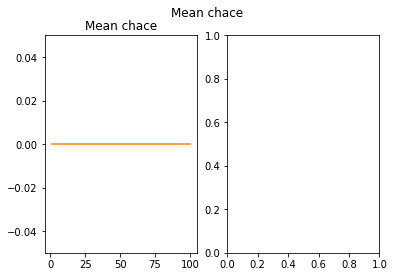

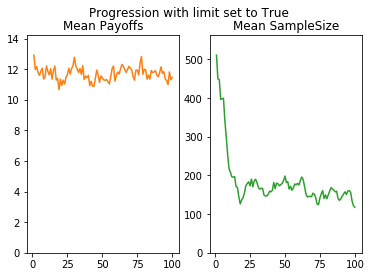

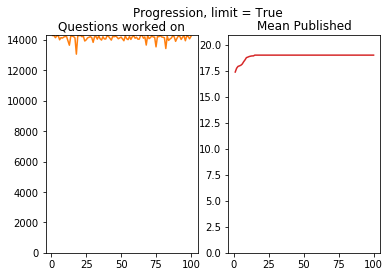

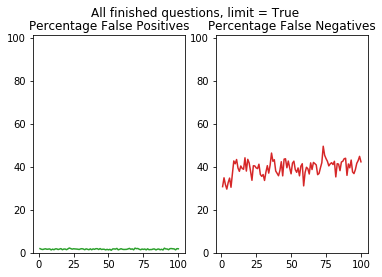

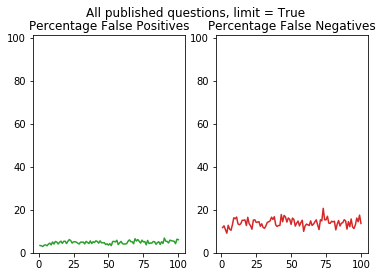

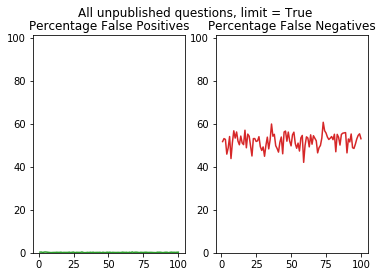

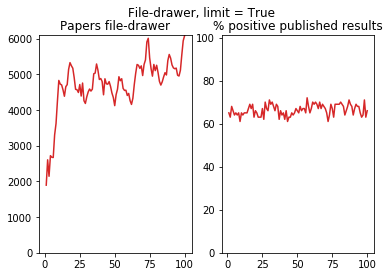

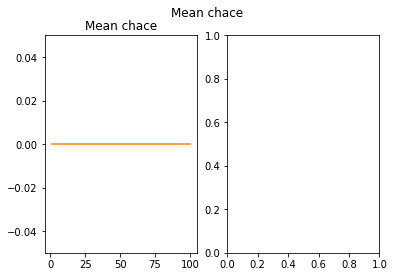

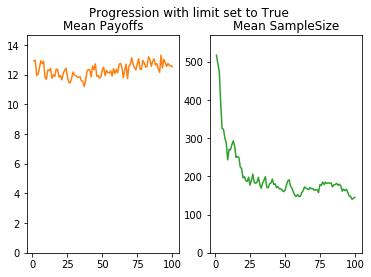

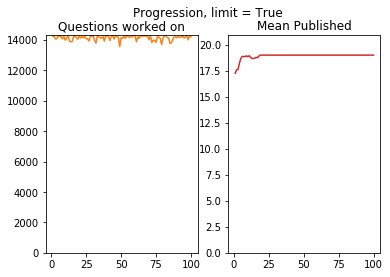

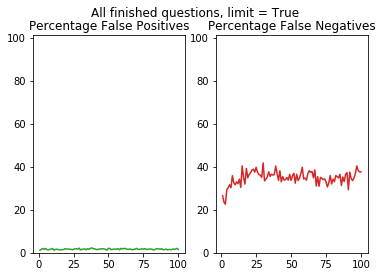

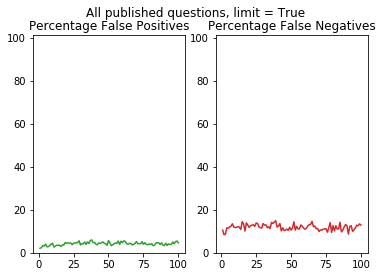

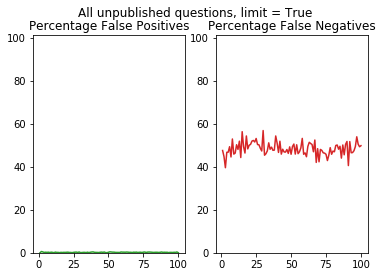

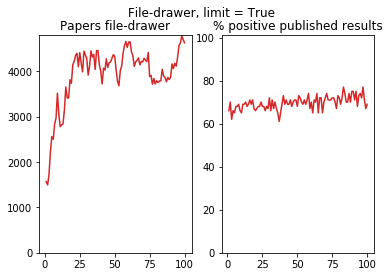

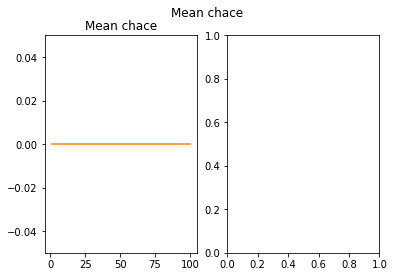

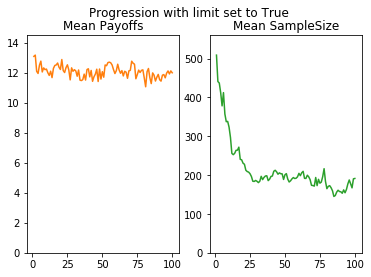

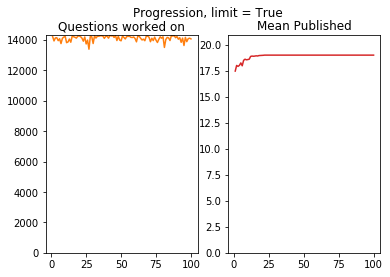

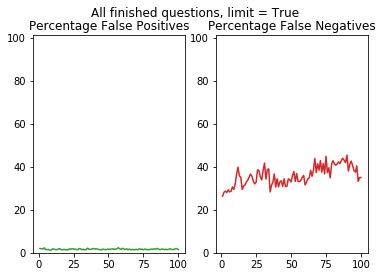

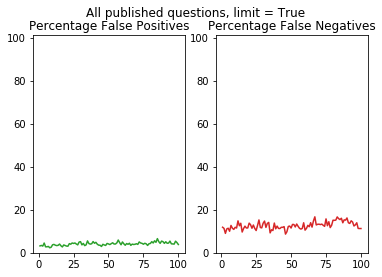

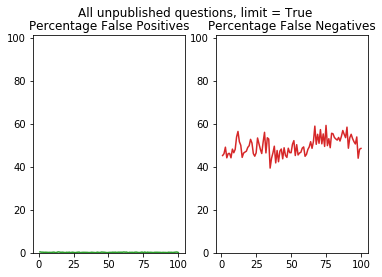

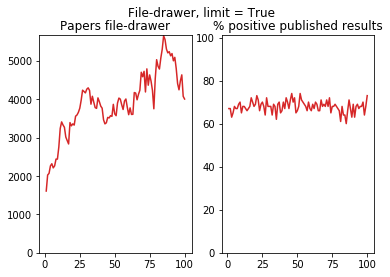

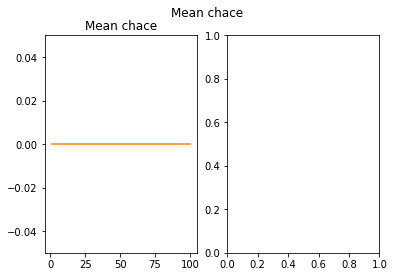

In [22]:
%%time
limit = True
evolution (lifeSpanT, scientistPerQuestionMaxT, generationsT, startupCostT, sampleCostT, ExpDistributionShapeT, scoopedCostT, negativeResultCostT, limit, newQuestionCost, randomChance, chance)

working on generation:  1 / 20
working on generation:  2 / 20
working on generation:  3 / 20
working on generation:  4 / 20
working on generation:  5 / 20
working on generation:  6 / 20
working on generation:  7 / 20
working on generation:  8 / 20
working on generation:  9 / 20
working on generation:  10 / 20
working on generation:  11 / 20
working on generation:  12 / 20
working on generation:  13 / 20
working on generation:  14 / 20
working on generation:  15 / 20
working on generation:  16 / 20
working on generation:  17 / 20
working on generation:  18 / 20
working on generation:  19 / 20
working on generation:  20 / 20
    FP all  FN all  FP pub  FN pub
0       18     343      18     342
1       12     380      12     379
2       13     384      13     383
3       16     403      16     402
4       14     479      14     479
5       15     415      15     414
6       10     449      10     446
7       11     413      11     410
8       12     455      12     453
9        8     402 

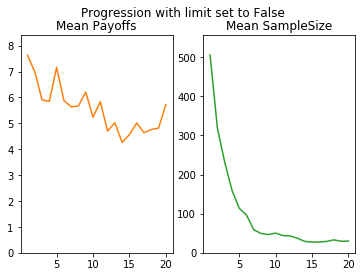

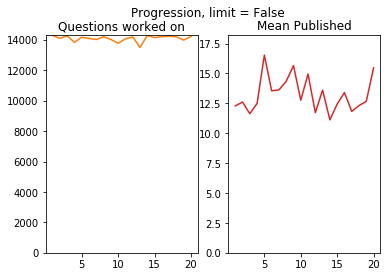

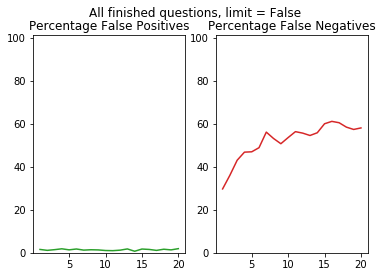

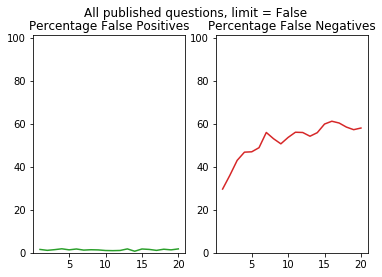

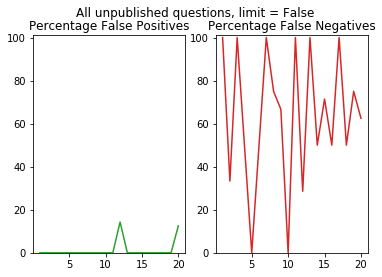

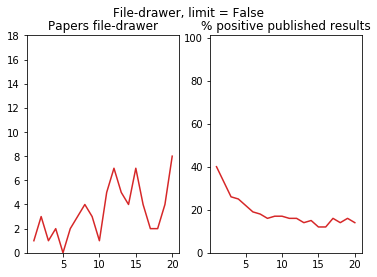

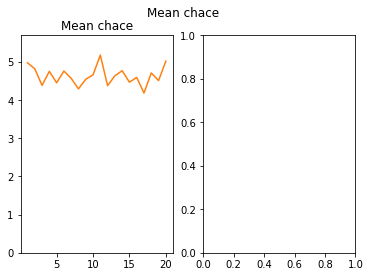

In [6]:
%%time
limit = False
evolution (lifeSpanT, scientistPerQuestionMaxT, generationsT, startupCostT, sampleCostT, ExpDistributionShapeT, scoopedCostT, negativeResultCostT, limit, newQuestionCost, randomChance, chance)

In [33]:
meanSamplesDataFrame = pd.DataFrame(data = meanSampleSizeOverRuns)
print(meanSamplesDataFrame)
meanPayoffDataFrame = pd.DataFrame(data = meanPayoffsOverRuns)
print(meanPayoffDataFrame)
meanSamplesDataFrame.to_csv('meanSamplesDataFrame.csv')
meanPayoffDataFrame.to_csv('meanPayoffDataFrame.csv')

           0           1           2           3           4           5   \
0  505.025000  457.741667  471.633333  443.641667  389.983333  367.733333   
1  477.975000  451.175000  462.116667  437.366667  403.950000  348.175000   
2  549.625000  482.283333  433.975000  400.425000  373.341667  392.133333   
3  495.200000  423.200000  372.191667  409.716667  410.325000  401.000000   
4  511.141667  489.158333  401.208333  369.000000  335.675000  311.483333   
5  486.516667  472.458333  446.400000  429.241667  415.225000  404.325000   
6  493.575000  416.991667  383.175000  335.775000  295.433333  273.908333   
7  510.341667  449.033333  447.266667  395.916667  397.766667  399.016667   
8  517.141667  493.825000  474.650000  392.725000  325.250000  323.400000   
9  509.083333  441.116667  437.200000  412.458333  378.375000  412.541667   

           6           7           8           9   ...          90  \
0  364.583333  341.500000  313.300000  297.258333  ...  126.633333   
1  277.90000